**Background:**

We are one of the fastest growing startups in the logistics and delivery domain. We work with several partners and make on-demand delivery to our customers. During the COVID-19 pandemic, we are facing several different challenges and everyday we are trying to address these challenges.

We thrive on making our customers happy. As a growing startup, with a global expansion strategy we know that we need to make our customers happy and the only way to do that is to measure how happy each customer is. If we can predict what makes our customers happy or unhappy, we can then take necessary actions.

Getting feedback from customers is not easy either, but we do our best to get constant feedback from our customers. This is a crucial function to improve our operations across all levels.

We recently did a survey to a select customer cohort. You are presented with a subset of this data. We will be using the remaining data as a private test set.

**Data Description:**

* Y = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers
* X1 = my order was delivered on time
* X2 = contents of my order was as I expected
* X3 = I ordered everything I wanted to order
* X4 = I paid a good price for my order
* X5 = I am satisfied with my courier
* X6 = the app makes ordering easy for me 

Attributes X1 to X6 indicate the responses for each question and have values from 1 to 5 where the smaller number indicates less and the higher number indicates more towards the answer. 

**Goal(s):**

* Predict if a customer is happy or not based on the answers they give to questions asked.

**Success Metrics:**

* Reach 73% accuracy score or above, or convince us why your solution is superior. We are definitely interested in every solution and insight you can provide us.
* Try to submit your working solution as soon as possible. The sooner the better. 

**Data exploration and features engineering**

In [623]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import chi2
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm, metrics
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report, plot_confusion_matrix
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [624]:
df = pd.read_csv('HappinessSurvey2020.csv')

In [625]:
df.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [626]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


Observation: We have 126 entries and 7 columns without missing value

In [627]:
df.describe(include="all")

,Y,X1,X2,X3,X4,X5,X6
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.547619,4.333333,2.531746,3.309524,3.746032,3.650794,4.253968
std,0.499714,0.800000,1.114892,1.023440,0.875776,1.147641,0.809311
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,4.000000,2.000000,3.000000,3.000000,3.000000,4.000000
50%,1.000000,5.000000,3.000000,3.000000,4.000000,4.000000,4.000000
75%,1.000000,5.000000,3.000000,4.000000,4.000000,4.000000,5.000000
max,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


happy: Y    54.761905
dtype: float64
unhappy: Y    45.238095
dtype: float64


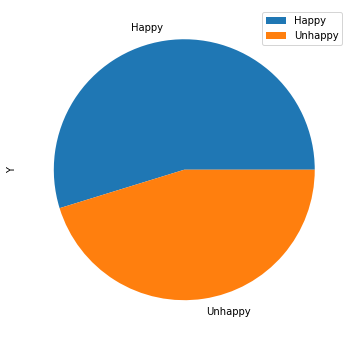

In [628]:
happy= df.loc[df['Y'] ==1]
unhappy= df.loc[df['Y']==0]
happy= happy.iloc[:, :1]
happy= happy.sum()
unhappy= df.shape[0]- happy
p = [happy, unhappy]
plt_data = pd.DataFrame(p)
plt_data.plot(kind='pie', subplots=True, labels=['Happy', 'Unhappy'],figsize=(6,6))
print("happy:",happy/(happy+unhappy)*100)
print("unhappy:",unhappy/(happy+unhappy)*100)

Based on the graph , we can observe that the data is slight unbalanced(54%-45%=9%)

**Dummy encoding for categorical data**

In [629]:
df_dummy = pd.get_dummies(df, columns=['X1', 'X2', 'X3', 'X4', 'X5', 'X6'], drop_first=True)

df_dummy

,Y,X1_3,X1_4,X1_5,X2_2,X2_3,X2_4,X2_5,X3_2,X3_3,...,X4_4,X4_5,X5_2,X5_3,X5_4,X5_5,X6_2,X6_3,X6_4,X6_5
0,0,1,0,0,0,1,0,0,0,1,...,1,0,1,0,0,0,0,0,1,0
1,0,1,0,0,1,0,0,0,0,1,...,0,1,0,0,1,0,0,1,0,0
2,1,0,0,1,0,1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1
3,0,0,0,1,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,1
4,0,0,0,1,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,1,0,0,1,1,0,0,0,0,1,...,1,0,0,0,1,0,0,1,0,0
122,1,0,0,1,1,0,0,0,0,1,...,1,0,1,0,0,0,0,0,0,1
123,1,0,0,1,0,1,0,0,0,1,...,1,0,0,0,1,0,0,0,0,1
124,0,0,1,0,0,1,0,0,0,1,...,1,0,0,0,1,0,0,0,0,1


In [630]:
# Putting feature variable to X
X = df_dummy.drop(['Y'], axis=1)
X.head()

,X1_3,X1_4,X1_5,X2_2,X2_3,X2_4,X2_5,X3_2,X3_3,X3_4,...,X4_4,X4_5,X5_2,X5_3,X5_4,X5_5,X6_2,X6_3,X6_4,X6_5
0,1,0,0,0,1,0,0,0,1,0,...,1,0,1,0,0,0,0,0,1,0
1,1,0,0,1,0,0,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0
2,0,0,1,0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
3,0,0,1,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
4,0,0,1,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1


In [631]:
# puttting target variable to y
y = df_dummy['Y']

In [632]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=1)

**Using Logistic Regression**

In [633]:
# scalling the data

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [634]:
# Make instance of the model
model = LogisticRegression()

In [635]:
model.fit(X_train, y_train)

LogisticRegression()

In [636]:
predictions = model.predict(X_test)

In [637]:
# Use score method to get accuracy of model
score = model.score(X_train, y_train)
print("Training score:",score*100)

Training score: 67.02127659574468


In [638]:
# Use score method to get accuracy of model
score = model.score(X_test, y_test)
print("Test score:",score*100)

Test score: 68.75


We have 67.02% on training set and 68.75% on test set as fisrt result using Logistic Regression. Let use another algorithms and see if we can get better performance.

/home/amath/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


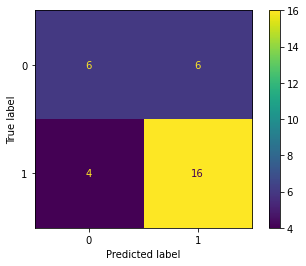

In [639]:
#print('Confusion Matrix')
plot_confusion_matrix(model, X_test, y_test)


* features selection using chistq test
* cross validation

**Feature Selection**

In [640]:
from sklearn.feature_selection import SelectKBest, chi2

In [641]:
# Putting feature variable to X
Xdf = df.drop(['Y'], axis=1)

# puttting target variable to y
ydf = df['Y']

# Splitting the data into train and test
Xdf_train, Xdf_test, ydf_train, ydf_test = train_test_split(Xdf, ydf, train_size=0.75, test_size=0.25, random_state=1)

Feature(0) X1: 1.414157
Feature(1) X2: 0.218818
Feature(2) X3: 0.464921
Feature(3) X4: 0.071758
Feature(4) X5: 1.675030
Feature(5) X6: 0.839318


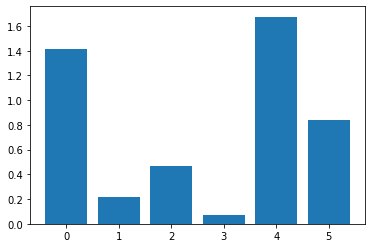

In [642]:
# feature selection
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(Xdf_train, ydf_train)
X_train_fs = fs.transform(Xdf_train)
X_test_fs = fs.transform(Xdf_test)

# scores for features
feature_names = ['X1','X2','X3','X4','X5','X6']
for i in range(len(fs.scores_)):
    print('Feature(%d) %s: %f' % (i, feature_names[i], fs.scores_[i]))

# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

We can observe that features X5 and X1 are more corralated to the target variable Y

**Create the model and use cross validation**



*   Let first work with all features



In [643]:
def model_performance(Xlr,ylr):
    # Spot Check Algorithms
    models = []
    models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('DesTree', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('SVM', SVC(gamma='auto')))
    models.append(('RF', RandomForestClassifier(max_depth=6, random_state=100)))
    ratio = float(np.sum(ylr == 0)) / np.sum(ylr==1)
    models.append(('XGB', XGBClassifier(scale_pos_weight = ratio, learning_rate =0.01,
                        objective= 'binary:logistic', use_label_encoder=False, eval_metric='error')))

    # evaluate each model in turn
    results = []
    names = []
    for name, model in models:
        kfold = StratifiedKFold(n_splits=10, random_state=100, shuffle=True)
        cv_results = cross_val_score(model, Xlr, ylr, cv=kfold, scoring='accuracy')
        results.append(cv_results)
        names.append(name)
        print('%s: %.2f (%.2f)' % (name, cv_results.mean()*100, cv_results.std()))
    _ = plt.bar(names,np.mean(results, axis=1)*100)

LR: 53.11 (0.17)
LDA: 50.00 (0.18)
KNN: 51.89 (0.13)
DesTree: 63.11 (0.20)
NB: 53.44 (0.06)
SVM: 51.22 (0.11)
RF: 61.78 (0.14)
XGB: 55.44 (0.17)


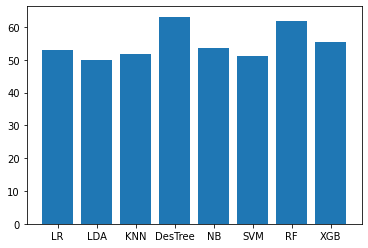

In [644]:
model_performance(X_train, y_train)

Now by just considering required features, lets evaluate above models again. Based on the feature scores, lets set the value of k=3.

In [645]:
# feature selection
def select_features_chi(X_train, y_train, X_test):
    fs = SelectKBest(score_func=chi2, k=3)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [646]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# feature selection (chi2)
X_train_cfs, X_test_cfs, cfs = select_features_chi(X_train, y_train, X_test)

LR: 59.89 (0.15)
LDA: 59.89 (0.15)
KNN: 43.44 (0.14)
DesTree: 58.78 (0.13)
NB: 57.78 (0.11)
SVM: 58.78 (0.13)
RF: 60.89 (0.11)
XGB: 61.00 (0.15)


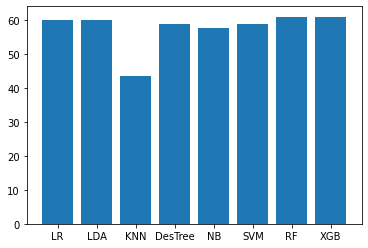

In [647]:
model_performance(X_train_cfs, y_train)

**Performance Logistic Regression: LR**

In [648]:
rfcModel = LogisticRegression(solver='liblinear', multi_class='ovr')
rfcModel.fit(X_train_cfs, y_train)
predictions = rfcModel.predict(X_test_cfs)

# Evaluate predictions
print('Testing Accuracy: %.2f \n' % (accuracy_score(y_test, predictions)*100))
print('Confusion matrix:')
print(confusion_matrix(y_test, predictions))
print('\nClassification Report:\n')
print(classification_report(y_test, predictions))

Testing Accuracy: 65.62 

Confusion matrix:
[[ 6  8]
 [ 3 15]]

Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.43      0.52        14
           1       0.65      0.83      0.73        18

    accuracy                           0.66        32
   macro avg       0.66      0.63      0.63        32
weighted avg       0.66      0.66      0.64        32



* The model is not performing well in terms of accuracy(59.89% in training set and 65.62% in test set.)

**Linear Discrimination Analysis: LDA**

In [649]:
rfcModel = LinearDiscriminantAnalysis()
rfcModel.fit(X_train_cfs, y_train)
predictions = rfcModel.predict(X_test_cfs)

# Evaluate predictions
print('Testing Accuracy: %.2f \n' % (accuracy_score(y_test, predictions)*100))
print('Confusion matrix:')
print(confusion_matrix(y_test, predictions))
print('\nClassification Report:\n')
print(classification_report(y_test, predictions))

Testing Accuracy: 65.62 

Confusion matrix:
[[ 6  8]
 [ 3 15]]

Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.43      0.52        14
           1       0.65      0.83      0.73        18

    accuracy                           0.66        32
   macro avg       0.66      0.63      0.63        32
weighted avg       0.66      0.66      0.64        32



* The model is not performing well in terms of accuracy(59.89% in training set and 65.62% in test set.)

**K Nearest Neighbor: KNN**

In [650]:
rfcModel = KNeighborsClassifier()
rfcModel.fit(X_train_cfs, y_train)
predictions = rfcModel.predict(X_test_cfs)

# Evaluate predictions
print('Testing Accuracy: %.2f \n' % (accuracy_score(y_test, predictions)*100))
print('Confusion matrix:')
print(confusion_matrix(y_test, predictions))
print('\nClassification Report:\n')
print(classification_report(y_test, predictions))

Testing Accuracy: 56.25 

Confusion matrix:
[[ 0 14]
 [ 0 18]]

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.56      1.00      0.72        18

    accuracy                           0.56        32
   macro avg       0.28      0.50      0.36        32
weighted avg       0.32      0.56      0.40        32



/home/amath/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amath/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amath/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


* KNN model is not performing well(Training Accuracy: 43.44% , Testing Accuracy: 56.25). It's the worse model

**Decision Tree Classifier: DesTree**

In [651]:
rfcModel = DecisionTreeClassifier()
rfcModel.fit(X_train_cfs, y_train)
predictions = rfcModel.predict(X_test_cfs)

# Evaluate predictions
print('Testing Accuracy: %.2f \n' % (accuracy_score(y_test, predictions)*100))
print('Confusion matrix:')
print(confusion_matrix(y_test, predictions))
print('\nClassification Report:\n')
print(classification_report(y_test, predictions))

Testing Accuracy: 65.62 

Confusion matrix:
[[ 6  8]
 [ 3 15]]

Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.43      0.52        14
           1       0.65      0.83      0.73        18

    accuracy                           0.66        32
   macro avg       0.66      0.63      0.63        32
weighted avg       0.66      0.66      0.64        32



* The model is not performing well in terms of accuracy(58.78% in training set and 65.62% in test set.)

**Naive Bayes: NB**

In [652]:
rfcModel = GaussianNB()
rfcModel.fit(X_train_cfs, y_train)
predictions = rfcModel.predict(X_test_cfs)

# Evaluate predictions
print('Testing Accuracy: %.2f \n' % (accuracy_score(y_test, predictions)*100))
print('Confusion matrix:')
print(confusion_matrix(y_test, predictions))
print('\nClassification Report:\n')
print(classification_report(y_test, predictions))

Testing Accuracy: 65.62 

Confusion matrix:
[[ 6  8]
 [ 3 15]]

Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.43      0.52        14
           1       0.65      0.83      0.73        18

    accuracy                           0.66        32
   macro avg       0.66      0.63      0.63        32
weighted avg       0.66      0.66      0.64        32



* The model is not performing well in terms of accuracy(57.78% in training set and 65.62% in test set.)

**Support Vector Machine: SVM**

In [653]:
rfcModel = SVC(gamma='auto')
rfcModel.fit(X_train_cfs, y_train)
predictions = rfcModel.predict(X_test_cfs)

# Evaluate predictions
print('Testing Accuracy: %.2f \n' % (accuracy_score(y_test, predictions)*100))
print('Confusion matrix:')
print(confusion_matrix(y_test, predictions))
print('\nClassification Report:\n')
print(classification_report(y_test, predictions))

Testing Accuracy: 78.12 

Confusion matrix:
[[10  4]
 [ 3 15]]

Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.71      0.74        14
           1       0.79      0.83      0.81        18

    accuracy                           0.78        32
   macro avg       0.78      0.77      0.78        32
weighted avg       0.78      0.78      0.78        32



* The SVM model is better compare to the previous models (58.78% in training set and 78.12% in test set.) and greater than the target accuracy(73%)

**Performance Random Forest**

In [654]:
rfcModel = RandomForestClassifier(max_depth=6, random_state=100)
rfcModel.fit(X_train_cfs, y_train)
predictions = rfcModel.predict(X_test_cfs)

# Evaluate predictions
print('Testing Accuracy: %.2f \n' % (accuracy_score(y_test, predictions)*100))
print('Confusion matrix:')
print(confusion_matrix(y_test, predictions))
print('\nClassification Report:\n')
print(classification_report(y_test, predictions))

Testing Accuracy: 65.62 

Confusion matrix:
[[ 6  8]
 [ 3 15]]

Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.43      0.52        14
           1       0.65      0.83      0.73        18

    accuracy                           0.66        32
   macro avg       0.66      0.63      0.63        32
weighted avg       0.66      0.66      0.64        32



* The model is not performing well in terms of accuracy(60.89% in training set and 65.62% in test set.)

**Performance XGBoost**

In [655]:
ratio = float(np.sum(y_train == 0)) / np.sum(y_train==1)
xgbModel = XGBClassifier(scale_pos_weight = ratio, learning_rate =0.1,
                        objective= 'binary:logistic', use_label_encoder=False, eval_metric='error')
xgbModel.fit(X_train_cfs, y_train)
predictions = xgbModel.predict(X_test_cfs)

# Evaluate predictions
print('Testing Accuracy: %.2f \n' % (accuracy_score(y_test, predictions)*100))
print('Confusion matrix:')
print(confusion_matrix(y_test, predictions))
print('\nClassification Report:\n')
print(classification_report(y_test, predictions))

Testing Accuracy: 78.12 

Confusion matrix:
[[10  4]
 [ 3 15]]

Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.71      0.74        14
           1       0.79      0.83      0.81        18

    accuracy                           0.78        32
   macro avg       0.78      0.77      0.78        32
weighted avg       0.78      0.78      0.78        32



* XGBoost is able to reach the same accuracy than SVM on test data (61.00% in training set and 78.12% in test set.) and greater than the target accuracy(73%)

**Conclusion**


1.   XGBoost and SVM are out performing the target accuracy with an accuracy equal to 78.12%. 
2.   Theses 2 algorithms perform better than others when the data samples is not big. 
3. For perspective, we can add more data and remove X2 from next survey since the score was too low 

